In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - Stable Diffusion V2.1

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_2_1.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
    (a Python-3 GPU notebook with preinstalled HuggingFace/transformer libraries is recommended)
  </td>
</table>

## Overview

This notebook demonstrates running local inference for [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1) on either [Colab](https://colab.research.google.com) or [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench). This notebook also demonstrates finetuning stabilityai/stable-diffusion-2-1 with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth) and deploying it on Vertex AI for online prediction.

### Objective

- Run local predictions for text-to-image and text-guided-image-to-image with serving dockers.
- Finetune the stabilityai/stable-diffusion-2-1 model with [Dreambooth](https://huggingface.co/docs/diffusers/training/dreambooth).
- Upload the model to [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model to a [Vertex AI Endpoint resource](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for text-to-image and text-guided-image-to-image.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

**NOTE**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Setup notebook

#### Colab only
Run the following commands for Colab and skip this section if you are using Workbench.

In [1]:
if "google.colab" in str(get_ipython()):
    ! pip3 install --upgrade google-cloud-aiplatform
    from google.colab import auth as google_auth

    google_auth.authenticate_user()
    ! pip3 install --upgrade pip
    ! pip3 install torchvision==0.14.1
    ! pip3 install transformers==4.27.1
    ! pip3 install diffusers==0.15.1
    ! pip3 install datasets==2.9.0
    ! pip3 install accelerate==0.18.0
    ! pip3 install triton==2.0.0.dev20221120
    ! pip3 install xformers==0.0.16
    # Install gdown for downloading example training images.
    ! pip3 install gdown
    # Remove wrong cublas version.
    ! pip3 uninstall nvidia_cublas_cu11 --yes

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.2 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.1

#### Workbench only
1.   Follow [this link](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_stable_diffusion_inpainting.ipynb) to deploy the notebook to a Vertex AI Workbench Instance.
2.   Select `Create a new Notebook`.
3.   Click `Advanced Options`.
4.   In the **Environment** tab, select `Debian 10` for **Operating System** and select `Custom Container` for **Environment**.
5.   Set `Docker container image` to `us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/transformers-notebook`.
6.   Under **Machine configuration**, select 1 `T4` GPU and select `Install NVIDIA GPU driver automatically for me`.
7.   Click `Create` to create the Vertex AI Workbench instance.

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

1. [Create a service account](https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console) with `Vertex AI User` and `Storage Object Admin` roles for deploying fine tuned model to Vertex AI endpoint.

Fill following variables for experiments environment:

In [1]:
# Cloud project id.
PROJECT_ID = "acn-lkmaigcp"  # @param {type:"string"}

# The region you want to launch jobs in.
REGION = "us-central1"  # @param {type:"string"}

# The Cloud Storage bucket for storing experiments output. Fill it without the 'gs://' prefix.
GCS_BUCKET = ""  # @param {type:"string"}

# The service account for deploying fine tuned model.
SERVICE_ACCOUNT = ""  # @param {type:"string"}

Initialize Vertex-AI API:

In [2]:
from google.cloud import aiplatform

aiplatform.init(project= "acn-lkmaigcp", location="us-central1", staging_bucket=GCS_BUCKET)

### Define constants

In [3]:
# The pre-built training docker image. It contains training scripts and models.
TRAIN_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-diffusers-train:latest"

# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-diffusers-serve"

### Define common functions

In [4]:
import base64
import glob
import os
from datetime import datetime
from io import BytesIO

import requests
from google.cloud import aiplatform, storage
from PIL import Image


def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def deploy_model(model_id, task):
    model_name = "stable-diffusion-v2"
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-{task}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/diffusers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="n1-standard-8",
        accelerator_type="NVIDIA_TESLA_V100",
        accelerator_count=1,
        deploy_request_timeout=1800,
        service_account=SERVICE_ACCOUNT,
    )
    return model, endpoint


def get_bucket_and_blob_name(filepath):
    # The gcs path is of the form gs://<bucket-name>/<blob-name>
    gs_suffix = filepath.split("gs://", 1)[1]
    return tuple(gs_suffix.split("/", 1))


def upload_local_dir_to_gcs(local_dir_path, gcs_dir_path):
    """Uploads files in a local directory to a GCS directory."""
    client = storage.Client()
    bucket_name = gcs_dir_path.split("/")[2]
    bucket = client.get_bucket(bucket_name)
    for local_file in glob.glob(local_dir_path + "/**"):
        if not os.path.isfile(local_file):
            continue
        filename = local_file[1 + len(local_dir_path) :]
        gcs_file_path = os.path.join(gcs_dir_path, filename)
        _, blob_name = get_bucket_and_blob_name(gcs_file_path)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(local_file)
        print("Copied {} to {}.".format(local_file, gcs_file_path))

## Run inferences locally

### Text-to-image

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

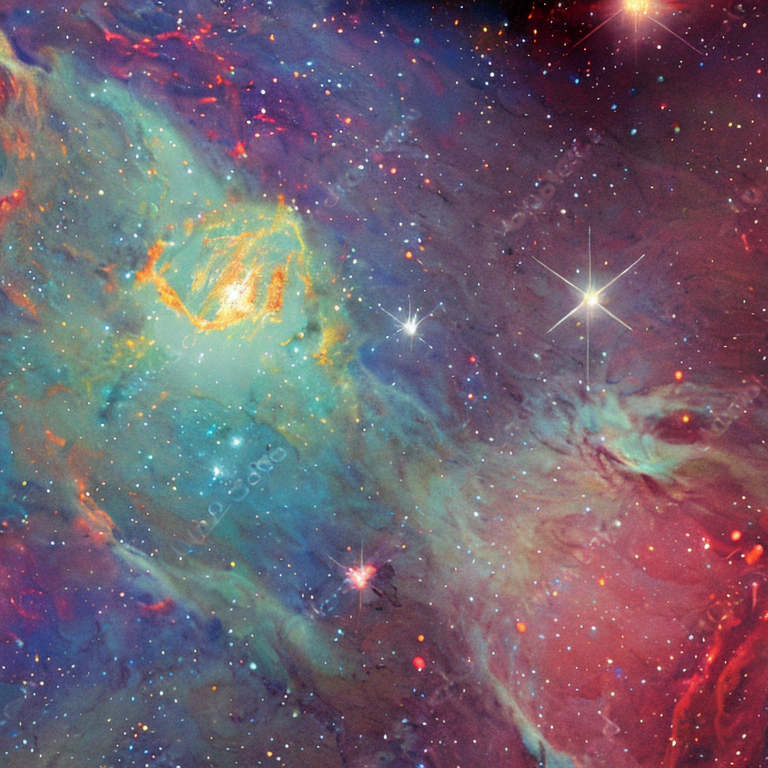

In [5]:
import torch
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)
pipe.enable_attention_slicing()

prompt = """
  a picture of the universe, showing sea of stars, Nebula and Supernova
  elegant, detailed digital painting"""

results = pipe(prompt=prompt)
images = results.images
display(images[0])

### Text-guided image-to-image

  0%|          | 0/40 [00:00<?, ?it/s]

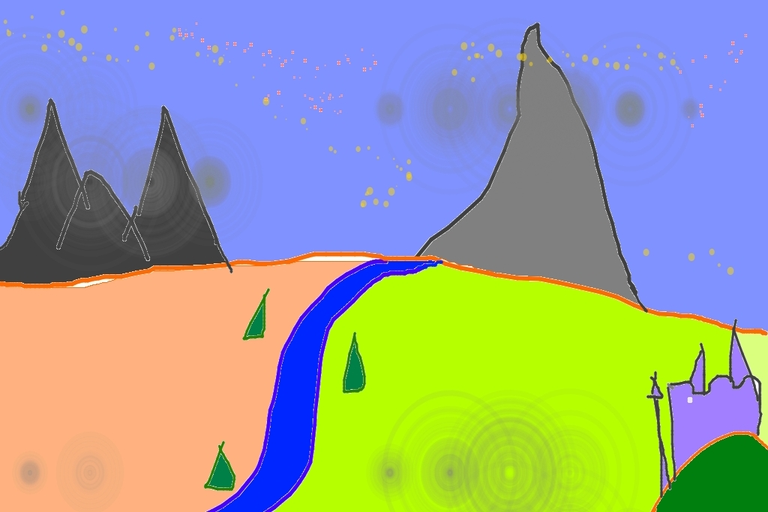

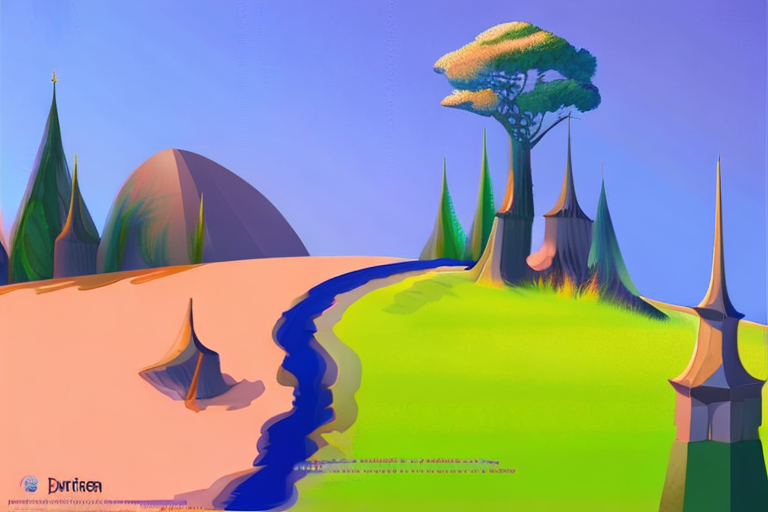

In [6]:
import torch
from diffusers import (DPMSolverMultistepScheduler,
                       StableDiffusionImg2ImgPipeline)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)
pipe.enable_attention_slicing()

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

results = pipe(prompt=prompt, image=init_image)
images = results.images
display(init_image)
display(images[0])

## Upload and Deploy models

This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take ~15 minutes to complete.

### Text-to-image

In [ ]:
# Undeploy model and delete endpoint.
endpoint.delete(force=True)

# Delete models.
model.delete()